# Aula 1 - Aprendizado Não Supervisionado - Criando nosso primeiro algoritmo de Clustering ($K$-Means Clustering)

Prof. Dr. Ahirton Lopes

Ref. https://www.kaggle.com/code/parulpandey/penguin-dataset-the-new-iris

Baseado no original de Dennis Sun (Universidade de Stanford, 2024)


## Lendo os dados

In [50]:
import numpy as np
import pandas as pd

data_dir = "https://raw.githubusercontent.com/ahirtonlopes/Unsupervised_Learning/main/"
df_penguins = pd.read_csv(data_dir + "penguins.csv")
df_penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


Vamos nos concentrar em apenas duas das variáveis, a profundidade do bico e o comprimento da nadadeira, para que possamos visualizar facilmente os dados. Com base no gráfico de dispersão abaixo, quantos clusters existem neste conjunto de dados? Você pode criar um algoritmo que identifique automaticamente esses clusters?

<Axes: xlabel='bill_depth_mm', ylabel='flipper_length_mm'>

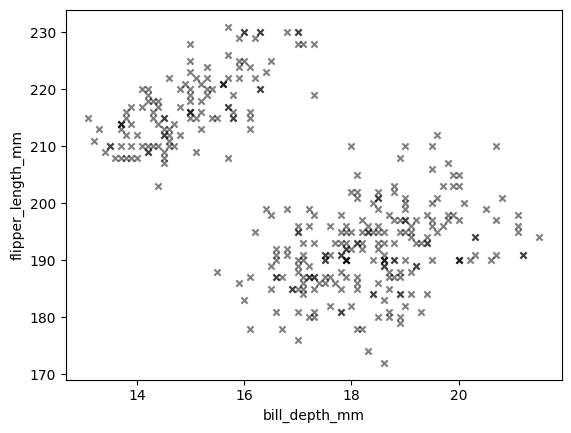

In [51]:
X_train = df_penguins[["bill_depth_mm", "flipper_length_mm"]].dropna()
X_train.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                     c="black", marker="x", alpha=.5)

Essas duas variáveis estão em escalas muito diferentes, então precisaremos escalá-las primeiro.

In [52]:
X_train_scaled = (X_train - X_train.mean()) / X_train.std()

## Implementando K-Means do zero (from scratch)

$K$-means é um algoritmo para encontrar clusters em dados. A ideia por trás de $k$-means é simples: cada cluster tem um ponto “central” chamado **centróide**, e cada observação é atribuída ao cluster de seu centróide mais próximo. O desafio é encontrar os centróides certos. O algoritmo $k$-means começa com uma estimativa aleatória para os centróides e os melhora iterativamente.

As etapas são as seguintes:

1. Inicialize $k$ centróides aleatoriamente.
2. Atribua cada ponto ao cluster do centróide mais próximo.
3. (Após a reatribuição, cada centróide pode não estar mais no centro do seu cluster.) Recalcule cada centróide com base nos pontos atribuídos ao seu cluster.
4. Repita as etapas 2 e 3 até que nenhum ponto mude de cluster.

Primeiro, implementaremos o algoritmo $k$-means do zero. Primeiro, vamos amostrar 3 observações aleatoriamente dos dados dos pinguins para servir como centróides iniciais.

,bill_depth_mm,flipper_length_mm
r,-0.836123,1.001641
b,0.075365,-1.131811
y,0.328556,-1.416272


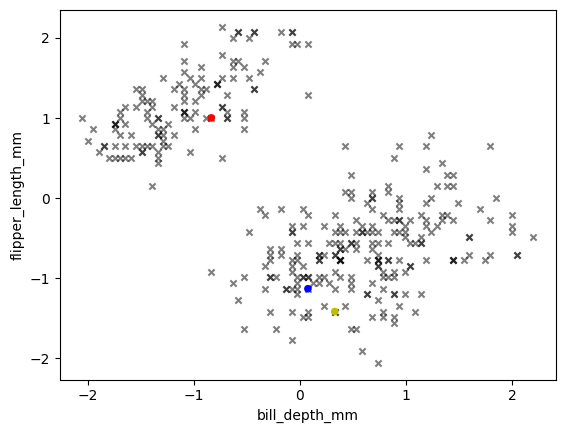

In [53]:
# Inicializando 3 centróides aleatoriamente a partir dos dados.
centroids = X_train_scaled.sample(3)

# Chamando os três clusters de "vermelho", "azul" e "amarelo" por conveniência.
centroids.index = ["r", "b", "y"]

# Plotando esses centróides.
ax = X_train_scaled.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                                 c="black", marker="x", alpha=.5)
centroids.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                       c=centroids.index, ax=ax)

centroids

Agora atribuímos cada ponto ao cluster do seu centróide mais próximo.

In [54]:
# Encontra o centróide mais próximo de uma determinada observação.
def get_nearest_centroid(obs):
    dists = np.sqrt(((obs - centroids) ** 2).sum(axis=1))
    return dists.idxmin()

get_nearest_centroid(X_train_scaled.loc[0])

'y'

<Axes: xlabel='bill_depth_mm', ylabel='flipper_length_mm'>

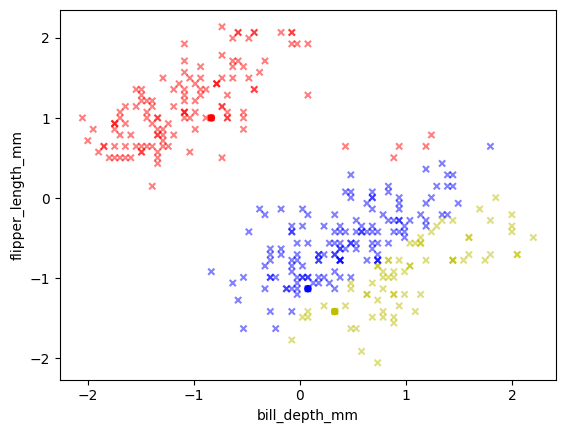

In [55]:
# Aplicando a função a todo o conjunto de dados.
clusters = X_train_scaled.apply(get_nearest_centroid, axis=1)

# Plotando as atribuições do cluster.
ax = X_train_scaled.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                                 c=clusters, marker="x", alpha=.5)
centroids.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                       c=centroids.index, ax=ax)

Observe que alguns dos centróides não estão mais no centro de seus aglomerados. Podemos corrigir isso redefinindo o centróide como a média dos pontos no seu cluster.

,bill_depth_mm,flipper_length_mm
b,0.399379,-0.543495
r,-1.018895,1.137205
y,1.032499,-0.955526


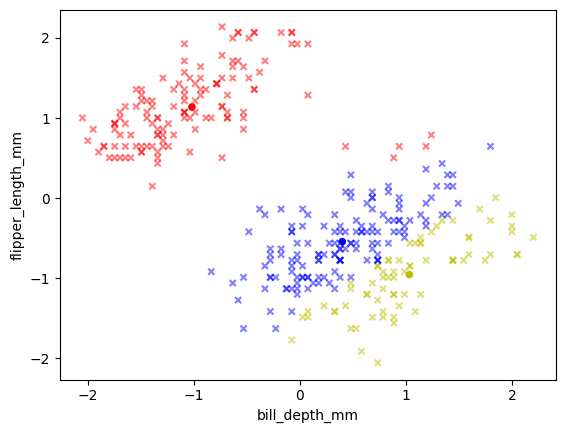

In [56]:
# Calculando o tamanho médio de cada cluster.
centroids = X_train_scaled.groupby(clusters).mean()

# Vamos plotar os centróides!
ax = X_train_scaled.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                                 c=clusters, marker="x", alpha=.5)
centroids.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                       c=centroids.index, ax=ax)

centroids

Agora, pode haver alguns pontos que não estão mais atribuídos ao seu centróide mais próximo, então temos que voltar e reatribuir os clusters. Mas isso pode fazer com que os centróides não estejam mais no centro do seu aglomerado, por isso temos que recalcular os centróides. E assim por diante. Esse processo continua até que as atribuições de cluster parem de mudar.

<Axes: xlabel='bill_depth_mm', ylabel='flipper_length_mm'>

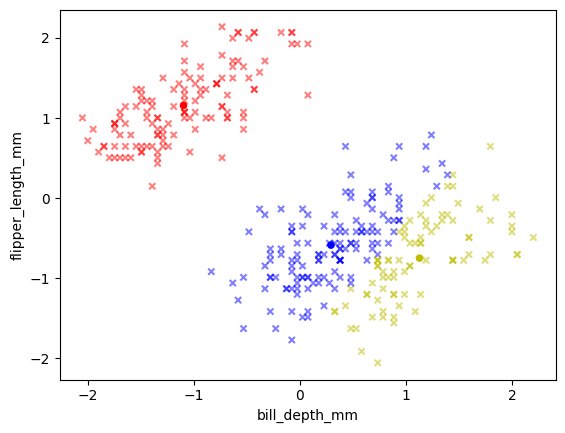

In [57]:
# Atribua pontos ao centróide mais próximo.
clusters = X_train_scaled.apply(get_nearest_centroid, axis=1)

# Recalculando os centróides com base nos clusters.
centroids = X_train_scaled.groupby(clusters).mean()

# Traçando as atribuições atuais do cluster e centróides.
ax = X_train_scaled.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                                 c=clusters, marker="x", alpha=.5)
centroids.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                       c=centroids.index, ax=ax)

Podemos executar o código na célula acima repetidamente até que os clusters parem de mudar. Esta é a atribuição final do cluster.

# $K$-Means em _scikit-learn_

Raramente precisamos implementar o algoritmo $k$-means do zero porque ele está disponível no _scikit-learn_. A API para o modelo $k$-means do _scikit-learn_ é semelhante à API para modelos de aprendizagem supervisionada, como $k$-vizinhos mais próximos, exceto que o método `.fit()` aceita apenas `X`, não `X ` e `y`. Isso faz sentido porque no aprendizado não supervisionado não há rótulos `y` nos dados de treinamento.

In [58]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
pipeline = make_pipeline(
    StandardScaler(),
    model
)

pipeline.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3))])

In [59]:
# Extraindo os centróides e os clusters.
centroids = model.cluster_centers_
clusters = model.labels_

clusters

array([1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2,
       1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1,
       2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,

<Axes: xlabel='bill_depth_mm', ylabel='flipper_length_mm'>

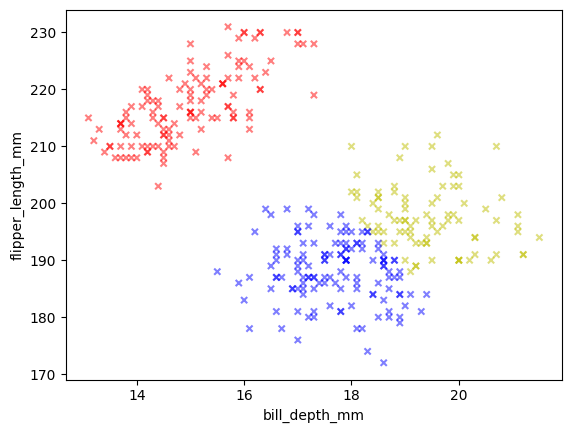

In [60]:
# Mapeando os números dos clusters para cores.
clusters = pd.Series(clusters).map({
    0: "r",
    1: "b",
    2: "y"
})

# Plotando os dados
X_train.plot.scatter(x="bill_depth_mm", y="flipper_length_mm",
                     c=clusters, marker="x", alpha=.5)

Podemos chamar `.predict()` para obter a atribuição de cluster para uma nova observação. Por exemplo, considere um pinguim com bico de 15 mm de profundidade e comprimento de nadadeira de 210 mm. Visualmente, é óbvio a qual cluster esse pinguim deve ser atribuído. Vamos verificar se este pinguim está realmente atribuído a esse cluster.

In [61]:
pipeline.predict([[15, 210]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0], dtype=int32)

Observe que `.predict()` simplesmente atribui a observação de teste ao cluster mais próximo sem recalcular os centróides. (Se esta observação estivesse nos dados de treinamento, então atribuí-la a um cluster moveria o centróide, o que por sua vez mudaria a atribuição dos outros pontos aos clusters, e assim por diante.)